In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import math
import skimage
import cv2

import helper
from split_images_to_patches import image_split

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras import Model
from skimage.measure import compare_ssim as ssim

%matplotlib inline

In [2]:
# to solve the issue of gpu memory lock
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#------------------------------------------#

In [3]:
helper.degrade_images('Test/', 2)

path Test/
Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving bridge.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving man.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


In [4]:
# compare the image quality metrics

for img in os.listdir('Test_degrded/'):
    
    lr = cv2.imread('Test_degrded/{}'.format(img))
    hr = cv2.imread('Test/{}'.format(img))
    
    # calculate the metrics
    metrics = helper.compare_images(lr, hr)
    
    print(lr.shape)
    
    # print the results
    #print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(img, metrics[0], metrics[1], metrics[2]))

(480, 500, 3)


/tf/notebooks/tf/TestCode/Image_Super_Resolution/helper.py:42: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  results.append(ssim(l_res, h_res, multichannel=True))


(512, 512, 3)
(576, 720, 3)
(288, 288, 3)
(512, 512, 3)
(256, 256, 3)
(288, 352, 3)
(361, 250, 3)
(276, 276, 3)
(362, 500, 3)
(288, 352, 3)
(280, 280, 3)
(512, 512, 3)
(512, 512, 3)
(512, 768, 3)
(512, 512, 3)
(656, 529, 3)
(344, 228, 3)
(391, 586, 3)


In [5]:
# build the SRCNN model

def srcnn_model():
    inputs = tf.keras.Input(shape=(None, None, 1))
    x = Conv2D(128, (9, 9), padding='valid', activation='relu',
               kernel_initializer='glorot_uniform', use_bias=True)(inputs)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_initializer='glorot_uniform', use_bias=True)(x)
    
    outputs = Conv2D(1, (5, 5), padding='same', activation='linear',
               kernel_initializer='glorot_uniform', use_bias=True)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='SRCNN')
    
    # define loss and optimizer
    optimizer = tf.keras.optimizers.Adam(lr=0.0003)
    
    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model
    

In [6]:
my_model = srcnn_model()
my_model.summary()

Model: "SRCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [7]:
# get the training 
PATCH_SIZE = 32
STRIDE = 14
FACTOR = 2

x_train, y_train = image_split('Train/', FACTOR, PATCH_SIZE, STRIDE)


In [8]:
print('Size:\n Training data: {}\n Training Labels: {}\n'.format(x_train.shape, y_train.shape))

Size:
 Training data: (22227, 32, 32, 1)
 Training Labels: (22227, 24, 24, 1)



In [ ]:
history = my_model.fit(x_train, y_train, epochs=200, batch_size=64)

In [ ]:
my_model.save_weights('epoch_200.h5', save_format="h5")

Degraded Image: 
PSNR: 30.916372297231234
MSE: 157.966278159763
SSIM: 0.800252405102723

Reconstructed Image: 
PSNR: 31.585842242682418
MSE: 135.39960310805523
SSIM: 0.825576964812568



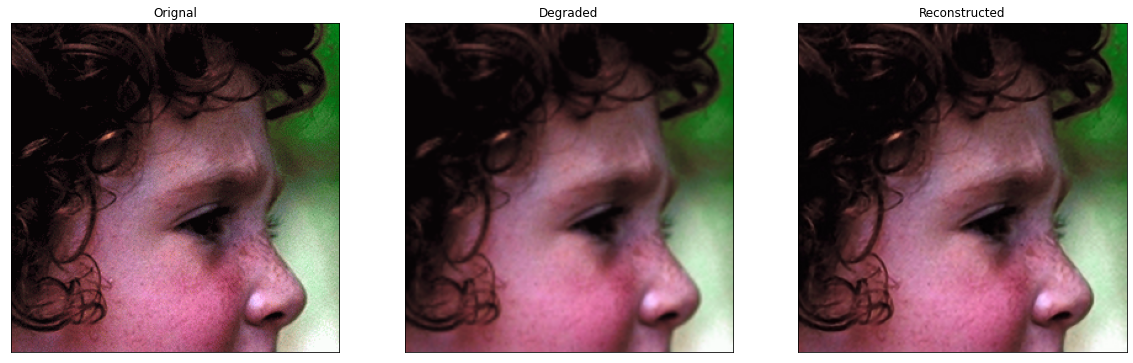

In [17]:
model = srcnn_model()
model.load_weights('epoch_200.h5')

test_path = 'Test_degrded/face.bmp'
path, file = os.path.split(test_path)

hr, lr, result, metrics = helper.test(test_path, model)

# compare the quality of images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(metrics[0][0], metrics[0][1], metrics[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(metrics[1][0], metrics[1][1], metrics[1][2]))

# display images side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(hr, cv2.COLOR_BGR2RGB))
axs[0].set_title('Orignal')
axs[1].imshow(cv2.cvtColor(lr, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axs[2].set_title('Reconstructed')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('Results/{}.png'.format(file[:-4]))